In [1]:
import os
import sys
import urllib, io
import pickle

import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.metrics import euclidean_distances, jaccard_score, pairwise_distances

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 
from IPython.core.display import HTML 

from io import BytesIO
import base64
import requests

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

sys.path.append("../../stimuli/block_utils/")
import blockworld_utils as utils

In [2]:
experiment_name = 'build_recall'

## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')

# paths specific to this experiment
experiment_results_dir = os.path.join(results_dir, experiment_name)
plot_dir = os.path.join(experiment_results_dir,'plots')
csv_dir = os.path.join(experiment_results_dir,'csv')
json_dir = os.path.join(experiment_results_dir,'json')

png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [3]:
# set vars 
auth = pd.read_csv(os.path.join(proj_dir, 'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['block_construction']
coll = db['build_components']

# which iteration name should we use?
# iteration_name = 'build_components_build_recall_prolific_pilot_12_towers'
# iteration_name = 'build_components_build_recall_prolific_pilot_6_towers_2_rep'
# iteration_name = 'build_components_build_recall_6_towers_3_rep_color_sona_pilot_0'
# iteration_name = 'build_components_build_recall_6_towers_3_rep_color_sona_pilot_1'
iteration_name = 'build_components_build_recall_wm_prolific_pilot_0'
iteration_names = [iteration_name]

In [4]:
! tunnel_cogtoolslab

zsh:1: command not found: tunnel_cogtoolslab


In [5]:
# all data
query = coll.find({"$and":[
                        {'iterationName': { '$in': iteration_names }},
                        ]})
df_all = pd.DataFrame(query)
print(len(df_all))

2642


In [6]:
df_all.columns

Index(['_id', 'rt', 'url', 'trial_type', 'trial_index', 'time_elapsed',
       'internal_node_id', 'experimentName', 'iterationName', 'workerID',
       'gameID', 'studyLocation', 'datatype', 'view_history', 'response',
       'success', 'timeout', 'failed_images', 'failed_audio', 'failed_video',
       'trial_start_time', 'trial_finish_time', 'condition', 'stimulus',
       'trial_num', 'towerColor', 'block_str', 'tower_id', 'tower_A_tall_id',
       'tower_A_wide_id', 'tower_B_tall_id', 'tower_B_wide_id',
       'tower_id_tall', 'composite_id', 'img_src', 'img_position', 'correct',
       'response_kind', 'absolute_time', 'locations', 'set_size',
       'distractor_imgs', 'target_img', 'stim', 'distractor_kinds',
       'n_blocks_when_reset', 'relative_time', 'n_block', 'n_resets',
       'timeAbsolute', 'timeRelative', 'blocks', 'discreteWorld', 'eventType',
       'block', 'endReason', 'rep', 'color'],
      dtype='object')

In [7]:
df_all.workerID.unique()

array(['6091c489c3688d18b644bb3e', '6155e5fbf44677ab2835421d',
       '5fdfea57516177866c94e957', '5faed1bd4a6f4d0840d39c2b',
       '61682673f052c4155cfe12f4', None, '5d4ba0be2fe36d00163e73db',
       '613a9a5a92a1c84fc4e3fd07', '60d360d3d604e89a278962cd',
       '6165adc8da33afc997acf508', '5fa87f95dd9aa4740b07da1a'],
      dtype=object)

In [8]:
# load metadata
query = coll.find({"$and":[
                        {'datatype':'metadata'},
                        {'iterationName': { '$in': iteration_names }},
                        ]})
df_meta = pd.DataFrame(query)
print(len(df_meta))

0


In [9]:
df_all.trial_type.unique()

array(['external-html', 'instructions', 'survey-text', 'preload',
       'block-tower-viewing', 'block-tower-match-to-sample', nan,
       'block-tower-building-undo-nostim',
       'block-tower-building-recall-choose-color'], dtype=object)

In [10]:
# learning/ exposure trials
learn_conditions = ['block-tower-match-to-sample','block-tower-building-undo-nostim']

query = coll.find({"$and":[
                        {'iterationName': { '$in': iteration_names }},
                        {'trial_type':{ '$in': learn_conditions }},
                        ]})
df_learn = pd.DataFrame(query)
print(len(df_learn))

180


In [24]:
df_learn.workerID.unique()

array(['613a9a5a92a1c84fc4e3fd07', '60d360d3d604e89a278962cd',
       '6165adc8da33afc997acf508', '5fa87f95dd9aa4740b07da1a',
       '5d4ba0be2fe36d00163e73db', None], dtype=object)

In [12]:
df_all.datatype.unique()

array(['trial_end', 'reset', 'block_placement', 'block_undo_placement',
       'block_redo_placement'], dtype=object)

In [13]:
# block placements
query = coll.find({"$and":[
                        {'datatype':'block_placement'},
                        {'iterationName': { '$in': iteration_names }},
                        ]})
df_blocks = pd.DataFrame(query)
print(len(df_blocks))

1568


In [14]:
# old-new judgements
query = coll.find({"$and":[
                        {'iterationName': { '$in': iteration_names }},
                        {'trial_type':'block-tower-build-recall'},
                        ]})
df_recall_trial = pd.DataFrame(query)
print(len(df_recall_trial))

0


In [16]:
# recalled towers one by one (in single recall trial)
query = coll.find({"$and":[
                        {'iterationName': { '$in': iteration_names }},
                        {'datatype':'recalled_tower'},
                        ]})
df_recalled_towers = pd.DataFrame(query)
print(len(df_recalled_towers))

0


In [17]:
# recalled towers one by one (across multiple recall trials i.e. in color experiments onwards)
query = coll.find({"$and":[
                        {'iterationName': { '$in': iteration_names }},
                        {'trial_type':'block-tower-building-recall-choose-color'},
                        ]})
df_recalled_towers = pd.DataFrame(query)
print(len(df_recalled_towers))

46


In [18]:
# old-new judgements
query = coll.find({"$and":[
                        {'iterationName': { '$in': iteration_names }},
                        {'datatype':'trial_end'},
                        ]})
df_trial = pd.DataFrame(query)
print(len(df_trial))

488


In [19]:
df_recalled_towers

,_id,timeAbsolute,timeRelative,blocks,discreteWorld,eventType,endReason,trial_start_time,relative_time,color,...,trial_type,trial_index,time_elapsed,internal_node_id,experimentName,iterationName,workerID,gameID,studyLocation,datatype
0,656e2da0c5c2296bd578c49a,1.701719e+12,960985.0,"[{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,submit-pressed,1.701719e+12,32576,"[145, 220, 39, 255]",...,block-tower-building-recall-choose-color,41,960603,0.0-23.0-0.0,block_construction_build_components,build_components_build_recall_wm_prolific_pilot_0,613a9a5a92a1c84fc4e3fd07,0970-66735e37-50be-40ae-81cb-7d45ba260acb,Prolific,trial_end
1,656e2dbbc5c2296bd578c4bb,1.701719e+12,988018.0,"[{'x': 6, 'y': 0, 'width': 2, 'height': 1}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,submit-pressed,1.701719e+12,24985,"[85, 111, 243, 255]",...,block-tower-building-recall-choose-color,42,987725,0.0-23.0-1.0,block_construction_build_components,build_components_build_recall_wm_prolific_pilot_0,613a9a5a92a1c84fc4e3fd07,0970-66735e37-50be-40ae-81cb-7d45ba260acb,Prolific,trial_end
2,656e2e46c5c2296bd578c543,1.701720e+12,1127004.0,"[{'x': 3, 'y': 0, 'width': 2, 'height': 1}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,submit-pressed,1.701719e+12,136788,"[150, 243, 227, 255]",...,block-tower-building-recall-choose-color,43,1126692,0.0-23.0-2.0,block_construction_build_components,build_components_build_recall_wm_prolific_pilot_0,613a9a5a92a1c84fc4e3fd07,0970-66735e37-50be-40ae-81cb-7d45ba260acb,Prolific,trial_end
3,656e2e4ec5c2296bd578c549,1.701720e+12,1131690.0,"[{'x': 4, 'y': 0, 'width': 2, 'height': 1}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,submit-pressed,1.701720e+12,51240,"[85, 111, 243, 255]",...,block-tower-building-recall-choose-color,41,1129874,0.0-23.0-0.0,block_construction_build_components,build_components_build_recall_wm_prolific_pilot_0,6165adc8da33afc997acf508,5021-bdc89216-f9bc-4c5d-a94d-d95cce3c1d6a,Prolific,trial_end
4,656e2e74c5c2296bd578c56c,1.701720e+12,1173271.0,"[{'x': 4, 'y': 0, 'width': 2, 'height': 1}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,submit-pressed,1.701720e+12,44045,"[101, 101, 101, 255]",...,block-tower-building-recall-choose-color,44,1173086,0.0-23.0-3.0,block_construction_build_components,build_components_build_recall_wm_prolific_pilot_0,613a9a5a92a1c84fc4e3fd07,0970-66735e37-50be-40ae-81cb-7d45ba260acb,Prolific,trial_end
5,656e2e8fc5c2296bd578c582,1.701720e+12,1196740.0,"[{'x': 4, 'y': 0, 'width': 2, 'height': 1}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,submit-pressed,1.701720e+12,63224,"[150, 243, 227, 255]",...,block-tower-building-recall-choose-color,42,1194948,0.0-23.0-1.0,block_construction_build_components,build_components_build_recall_wm_prolific_pilot_0,6165adc8da33afc997acf508,5021-bdc89216-f9bc-4c5d-a94d-d95cce3c1d6a,Prolific,trial_end
6,656e2e9fc5c2296bd578c590,NaN,NaN,NaN,NaN,NaN,give-up,1.701720e+12,40454,"[214, 186, 241, 255]",...,block-tower-building-recall-choose-color,45,1215843,0.0-23.0-4.0,block_construction_build_components,build_components_build_recall_wm_prolific_pilot_0,613a9a5a92a1c84fc4e3fd07,0970-66735e37-50be-40ae-81cb-7d45ba260acb,Prolific,trial_end
7,656e2ebdc5c2296bd578c5a2,1.701720e+12,1241871.0,"[{'x': 4, 'y': 0, 'width': 2, 'height': 1}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,submit-pressed,1.701720e+12,43293,"[214, 19, 87, 255]",...,block-tower-building-recall-choose-color,43,1240131,0.0-23.0-2.0,block_construction_build_components,build_components_build_recall_wm_prolific_pilot_0,6165adc8da33afc997acf508,5021-bdc89216-f9bc-4c5d-a94d-d95cce3c1d6a,Prolific,trial_end
8,656e2ec1c5c2296bd578c5a8,NaN,NaN,NaN,NaN,NaN,give-up,1.701720e+12,2847,"[214, 186, 241, 255]",...,block-tower-building-recall-choose-color,44,1244926,0.0-23.0-3.0,block_construction_build_components,b

### Exclusion criteria

In [20]:
df_all_trial = pd.concat([df_learn, df_recalled_towers], ignore_index=True)

In [21]:
# remove experimenter data
remove_tests = False

if remove_tests:
    df_build = df_build[~df_build.workerID.isna()]
    df_survey = df_survey[~df_survey.workerID.isna()]
    df_learn = df_learn[~df_learn.workerID.isna()]
    df_recall = df_recall[~df_recall.workerID.isna()]

In [41]:
df_learn.groupby(['workerID','gameID']).apply(len)

workerID                  gameID                                   
5d4ba0be2fe36d00163e73db  6584-44fa7f2b-29f7-4e63-a7b4-a52ae224e200    18
5fa87f95dd9aa4740b07da1a  9577-c301afe4-d98e-4695-b08d-5a38ddb8f796    18
60d360d3d604e89a278962cd  0351-20da748d-6f3f-4f31-8272-b8df3b55cab7    18
                          3308-76ef2b2c-5f23-4517-9c33-24ad31f83ffc    18
                          5640-2b0d2ce3-76a4-4da2-b9c2-95b795fa03a0    18
613a9a5a92a1c84fc4e3fd07  0970-66735e37-50be-40ae-81cb-7d45ba260acb    18
6165adc8da33afc997acf508  5021-bdc89216-f9bc-4c5d-a94d-d95cce3c1d6a    18
dtype: int64

In [42]:
# remove incomplete datasets (build recall)
remove_incomplete_datasets = True
n_expected_learn_trials = 18

if remove_incomplete_datasets:
    a = df_learn.groupby('gameID').apply(len) == n_expected_learn_trials
    complete_zipping_set_gameIDs = list(a[a].index)
    df_trials = df_all_trial[df_all_trial.gameID.isin(complete_zipping_set_gameIDs)]
    df_learn = df_learn[df_learn.gameID.isin(complete_zipping_set_gameIDs)]
    df_recalled_towers = df_recalled_towers[df_recalled_towers.gameID.isin(complete_zipping_set_gameIDs)]
    
    incomplete_zipping_set_gameIDs = list(a[~a].index)
    print(str(len(incomplete_zipping_set_gameIDs)) + ' ppts removed for incomplete data')
    print(str(len(complete_zipping_set_gameIDs)) + ' ppts left')
else: 
    print('No ppts removed')

0 ppts removed for incomplete data
10 ppts left


In [43]:
times = df_trials.sort_values(['workerID','trial_start_time']).groupby(['workerID'])\
            .first().reset_index()[['workerID','trial_start_time']]




In [44]:
df_trials.trial_start_time

0               NaN
1      1.701719e+12
2               NaN
3               NaN
4               NaN
           ...     
221    1.701794e+12
222    1.701794e+12
223    1.701794e+12
224    1.701794e+12
225    1.701794e+12
Name: trial_start_time, Length: 226, dtype: float64

(array([1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([1.70171860e+12, 1.70171862e+12, 1.70171863e+12, 1.70171864e+12,
        1.70171866e+12, 1.70171867e+12, 1.70171869e+12, 1.70171870e+12,
        1.70171871e+12, 1.70171873e+12, 1.70171874e+12, 1.70171876e+12,
        1.70171877e+12, 1.70171878e+12, 1.70171880e+12, 1.70171881e+12,
        1.70171883e+12, 1.70171884e+12, 1.70171885e+12, 1.70171887e+12,
        1.70171888e+12, 1.70171890e+12, 1.70171891e+12, 1.70171892e+12,
        1.70171894e+12, 1.70171895e+12, 1.70171897e+12, 1.70171898e+12,
        1.70171899e+12, 1.70171901e+12, 1.70171902e+12, 1.70171904e+12,
        1.70171905e+12, 1.70171906e+12, 1.70171908e+12, 1.70171909e+12,
        1.70171911e+12, 1.70171912e+12, 1.70171913e+12, 1.70171915e+12,
        1.70171916e+12, 1.70171918e+12, 1.70171919e+12

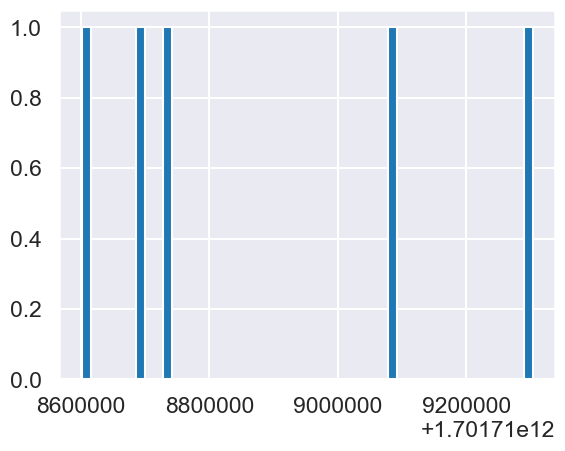

In [45]:
plt.hist(times.trial_start_time, bins=50)

#### Flag potentially weird behaviors

Flag:
- < 50% accuracy?
- button bashing on recall trials?
- fast rts on recall trials?

### Save data to csv

In [46]:
df_learn.to_csv(experiment_results_dir + '/df_learn_{}.csv'.format(iteration_name))
# df_trial.to_csv(experiment_results_dir + '/df_trial_{}.csv'.format(iteration_name))
df_recall_trial.to_csv(experiment_results_dir + '/df_recall_trial_{}.csv'.format(iteration_name))
df_recalled_towers.to_csv(experiment_results_dir + '/df_recalled_towers_{}.csv'.format(iteration_name))
df_blocks.to_csv(experiment_results_dir + '/df_blocks_{}.csv'.format(iteration_name))

In [47]:
experiment_results_dir + '/df_blocks_{}.csv'.format(iteration_name)

'/Users/will/zipping/results/build_recall/df_blocks_build_components_build_recall_wm_prolific_pilot_0.csv'

In [53]:
# df_trial = pd.read_csv(experiment_results_dir + '/df_trial_{}.csv'.format(iteration_name))
# df_trial

,Unnamed: 0,_id,trial_start_time,trial_finish_time,condition,stimulus,response,trial_num,block_str,tower_id,...,eventType,endReason,relative_time,rep,n_resets,absolute_time,total_recall_time,submitted_towers,concatenated_towers,n_towers
0,0,64274b0ee158fd5aa12435c5,1.680297e+12,1.680297e+12,view,"{'blocks': [{'x': 0, 'y': 0, 'height': 1, 'wid...",NaN,1,0000000000000000101000001010000011110000100100...,talls_114_111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,64274b4ee158fd5aa12435d2,1.680297e+12,NaN,build,"{'blocks': [{'x': 0, 'y': 0, 'height': 1, 'wid...",NaN,2,0000000000000000010100000101000011110000011000...,talls_097_100,...,trial_end,perfect-reconstruction-translation,59538.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2,2,64274b5ee158fd5aa12435d3,1.680297e+12,1.680297e+12,view,"{'blocks': [{'x': 1, 'y': 0, 'height': 2, 'wid...",NaN,3,0000000000000000110100000101000001110000111100...,talls_121_101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,64274b6fe158fd5aa12435d4,1.680297e+12,1.680297e+12,view,"{'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...",NaN,4,0000000000000000011100000110000011100000111100...,talls_102_126,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,64274b96e158fd5aa12435e8,1.680297e+12,NaN,build,"{'blocks': [{'x': 0, 'y': 0, 'height': 1, 'wid...",NaN,5,0000000000000000111000000110000001110000011000...,talls_118_114,...,trial_end,perfect-reconstruction-translation,34840.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,645,6446e103da7c3649c9c2a376,1.682366e+12,NaN,NaN,NaN,NaN,13,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.682367e+12,492318.0,"[{'towerDetails': {'blocks': [{'x': 4, 'y': 0,...","[{'height': 2, 'width': 1, 'x': 0, 'y': 0}, {'...",6.0
646,646,6446e20fda7c3649c9c2a419,1.682367e+12,NaN,NaN,NaN,NaN,61,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.682367e+12,283988.0,"[{'towerDetails': {'blocks': [{'x': 3, 'y': 0,...","[{'height': 1, 'width': 2, 'x': 0, 'y': 0}, {'...",4.0
647,647,6446e36bda7c3649c9c2a47a,1.682367e+12,NaN,NaN,NaN,NaN,13,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.682367e+12,733328.0,"[{'towerDetails': {'blocks': [{'x': 4, 'y': 0,...","[{'height': 2, 'width': 1, 'x': 1, 'y': 0}, {'...",6.0
648,648,6446e395da7c3649c9c2a485,1.682367e+12,NaN,NaN,NaN,NaN,13,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,1.682367e+12,135673.0,"[{'towerDetails': {'blocks': [{'x': 4, 'y': 0,...","[{'height': 2, 'width': 1, 'x': 1, 'y': 0}, {'...",4.0
